In [2]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from gym import spaces
from tqdm import tqdm

"""Environment imports"""
from epidemic_env.env       import Env, Log
from epidemic_env.dynamics  import ModelDynamics, Observation
from epidemic_env.visualize import Visualize
from epidemic_env.agent     import Agent, RussoAgent

"""Pytorch and numpy imports"""
import numpy as np
import torch
from torch import nn

%matplotlib inline

# Utils

In [3]:
def plot_trace_OG(log):
    # Extract rewards from log
    training_rewards = log['R_cumul']
    eval_rewards = log['eval_trace']

    # Generate x values
    x_train = range(len(training_rewards))
    x_eval = range(0, len(training_rewards), EVAL_INTERVAL)

    # Create new figure
    plt.figure()

    # Plot training trace
    plt.scatter(x_train, training_rewards, label='Training Trace', alpha=0.6)

    # Plot evaluation trace
    plt.plot(x_eval, eval_rewards, label='Eval Trace', color='red')

    # Add labels and legend
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.legend()

    # Show the plot
    plt.show()


In [4]:
def plot_trace(logs):
    # Create new figure
    plt.figure()

    # Initialize a list to store evaluation rewards for averaging
    avg_eval_rewards = []

    for idx, log in enumerate(logs):
        # Extract rewards from current log
        training_rewards = log['R_cumul']
        eval_rewards = log['eval_trace']

        # Generate x values
        x_train = range(len(training_rewards))
        x_eval = range(0, len(training_rewards), EVAL_INTERVAL)

        # Plot training trace
        plt.scatter(x_train, training_rewards, label=f'Training Trace {idx+1}', alpha=0.6)

        # Add current eval rewards to the list for averaging
        avg_eval_rewards.append(eval_rewards)

    # Average evaluation rewards across all training processes
    avg_eval_rewards = np.mean(avg_eval_rewards, axis=0)

    # Plot average evaluation trace
    plt.plot(x_eval, avg_eval_rewards, label='Avg Eval Trace', color='red')

    # Add labels and legend
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.legend()

    # Show the plot
    plt.show()


In [51]:
def run_simulation(agent, env, toggle = False):
    """ Run the simulation """
    log = []
    finished = False
    obs, info = env.reset(2)
    action_state = info.action
    #agent.reset()
    #agent.epsilon = 0
    while not finished:
        if not toggle:
                action = agent.act(obs)
        else:
            action = agent.act(obs, action_state)
        #action = agent.act(obs)
        obs, R, finished, info = env.step(action)
        action_state = info.action
        log.append(info) # save the information dict for logging
        if finished:
            break


    """ Parse the logs """
    total = {p:np.array([getattr(l.total,p) for l in log]) for p in dyn.parameters}
    cities = {c:{p:np.array([getattr(l.city[c],p) for l in log]) for p in dyn.parameters} for c in dyn.cities}
    actions = {a:np.array([l.action[a] for l in log]) for a in log[0].action.keys()}
    
    return total, cities, actions

In [6]:
def plot_simulation(total, cities, actions):
    fig = plt.figure(figsize=(14,10))
    ax_leftstate = plt.subplot2grid(shape=(9, 2), loc=(0, 0), rowspan=4)
    ax_leftobs = plt.subplot2grid(shape=(9, 2), loc=(4, 0), rowspan=3)
    ax_leftactions = plt.subplot2grid(shape=(9, 2), loc=(7, 0), rowspan=2)
    ax_right = [plt.subplot2grid(shape=(9, 2), loc=(0, 1), colspan=1)]
    ax_right += [plt.subplot2grid(shape=(9, 2), loc=(i, 1), colspan=1) for i in range(1,9)]
    ax_right = {k:ax_right[_id] for _id,k in enumerate(cities.keys())}

    [ax_leftstate.plot(y) for y in total.values()]
    ax_leftstate.legend(total.keys())
    ax_leftstate.set_title('Full state')
    ax_leftstate.set_ylabel('number of people in each state')

    [ax_leftobs.plot(total[y]) for y in ['infected','dead']]
    ax_leftobs.legend(['infected','dead'])
    ax_leftobs.set_title('Observable state')
    ax_leftobs.set_ylabel('number of people in each state')

    ax_leftactions.imshow(np.array([v for v in actions.values()]).astype(np.uint8),aspect='auto')
    ax_leftactions.set_title('Actions')
    ax_leftactions.set_yticks([0,1,2,3])
    ax_leftactions.set_yticklabels(list(actions.keys()))
    ax_leftactions.set_xlabel('time (in weeks)')

    [ax.plot(cities[c]['infected']) for c, ax in ax_right.items()]
    [ax.plot(cities[c]['dead']) for c, ax in ax_right.items()]
    [ax.set_ylabel(c) for c, ax in ax_right.items()]
    [ax.xaxis.set_major_locator(plt.NullLocator()) for c, ax in ax_right.items()]
    ax_right['Zürich'].set_xlabel('time (in weeks)')
    ax_right['Zürich'].xaxis.set_major_locator(MultipleLocator(2.000))

    fig.tight_layout()
    plt.show()

In [38]:
def run_several_simulations(agent, env, N_EPISODES = 50, toggle = False):
    # generate N seeds
    seeds = np.arange(N_EPISODES)
    log = {'Episode':[i+1 for i in range(N_EPISODES)],'conf_days':[], 'R_cumul':[], 'N_deaths':[]}

    """ Run several simulations """
    for i in tqdm(range(N_EPISODES)):
        finished = False
        obs, info = env.reset(seeds[i])
        action_state = info.action
        #agent.reset()
        #agent.epsilon = 0
        N_confin = 0
        R_cumul = 0

        while not finished:
            if not toggle:
                action = agent.act(obs)
            else:
                action = agent.act(obs, action_state)
            obs, R, finished, info = env.step(action)
            action_state = info.action

            R_cumul += R
            N_confin += info.action['confinement']*7

            if finished:
                break

        log['conf_days'].append(N_confin)
        log['R_cumul'].append(R_cumul.numpy()[0])
        log['N_deaths'].append(info.total.dead)
        
    return log

In [8]:
def plot_histograms(log):
    deaths = np.array(log['N_deaths'])
    rewards = np.array(log['R_cumul'])
    conf_days = np.array(log['conf_days'])


    """ Plot example """
    fig, ax = plt.subplots(3,1,figsize=(18,8))
    def hist_avg(ax, data,title):
        ymax = 50
        if title == 'deaths':
            x_range = (10000,140000)
        elif title == 'cumulative rewards': 
            x_range = (-300,100)
        elif 'days' in title:
            x_range = (25,150)
        else:
            raise ValueError(f'{title} is not a valid title') 
        ax.set_title(title)
        ax.set_ylim(0,ymax)
        ax.vlines([np.mean(data)],0,ymax,color='red')
        ax.hist(data,bins=60,range=x_range)
    hist_avg(ax[0], deaths,'deaths')
    hist_avg(ax[1], rewards,'cumulative rewards')
    hist_avg(ax[2], conf_days,'confined days')
    fig.tight_layout()
    plt.show()

    """ Print example """
    print(f'Average death number: {np.mean(deaths)}')
    print(f'Average number of confined days: {np.mean(conf_days)}')
    print(f'Average number of isolation days: {np.mean(conf_days)}')
    print(f'Average cumulative reward: {np.mean(rewards)}')

In [9]:
dyn = ModelDynamics('config/switzerland.yaml')   # load the switzerland map

# 3. Deep Q-Learning with a binary action space

# 3.1 Implementing Deep Q-Learning

In [10]:
SCALE = 1#00
ACTION_NULL = 0
ACTION_CONFINE = 1
ACTION_ISOLATE = 2
ACTION_HOSPITAL = 3
ACTION_VACCINATE = 4


def action_preprocessor(a:torch.Tensor, dyn:ModelDynamics):
    action = { # DO NOTHING
        'confinement': False, 
        'isolation': False, 
        'hospital': False, 
        'vaccinate': False,
    }
    
    if a == ACTION_CONFINE:
        action['confinement'] = True
    elif a == ACTION_ISOLATE:
        action['isolation'] = True
    elif a == ACTION_VACCINATE:
        action['vaccinate'] = True
    elif a == ACTION_HOSPITAL:
        action['hospital'] = True
        
    return action
    
def observation_preprocessor(obs: Observation, dyn:ModelDynamics):
    infected = SCALE * np.array([np.array(obs.city[c].infected)/obs.pop[c] for c in dyn.cities])
    dead = SCALE * np.array([np.array(obs.city[c].dead)/obs.pop[c] for c in dyn.cities])
    confined = np.ones_like(dead)*int((dyn.get_action()['confinement']))
    infected = infected**(1/4)
    dead = dead**(1/4)
    confined = confined
    return torch.Tensor(np.stack((infected, dead, confined))).unsqueeze(0)

In [11]:
action_space        =   spaces.Discrete(2)
observation_space   =   spaces.Box( low=0,
                                    high=1,
                                    shape=(2, dyn.n_cities, dyn.env_step_length),
                                    dtype=np.float16)

In [12]:
env = Env(  dyn,
            action_space=action_space,
            observation_space=observation_space,
            action_preprocessor=action_preprocessor,
            observation_preprocessor=observation_preprocessor,
            # Don't put observation preprocessor for this case because RussoAgent needs to know the population of each cities
            )

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import random

class DQNAgent:
    def __init__(self, state_dim, action_dim, env, epsilon = 0, memory_size=20000, seed = 0):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.memory = deque(maxlen=memory_size)
        self.model = self.create_model()
        self.target_model = self.create_model()
        self.update_target_model()
        self.optimizer = optim.Adam(self.model.parameters(), lr = 0.005)
        self.loss_fn = nn.HuberLoss()
        self.epsilon = epsilon
        self.env = env
        
        
    def load_model(self, savepath):
        # This is where one would define the routine for loading a pre-trained model
        self.model = torch.load(savepath)

    def save_model(self, savepath = 'best_model.pt'):
        # This is where one would define the routine for saving the weights for a trained model
        torch.save(self.model.state_dict(), savepath)

    def create_model(self):
        model = nn.Sequential(
            nn.Linear(self.state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, self.action_dim)
        )
        return model

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())
    
    def observation_to_state(self, observation):
        state = observation[0, :2]
        state = np.array(state.flatten())

        return state
        
    def act(self, obs):
        #print('state init', state)
        state = self.observation_to_state(obs)
        #print('stat post', state.shape, state)
        if random.random() < self.epsilon: # Exploration
            return random.choice(range(self.action_dim))
        else: # Exploitation
            state = torch.FloatTensor(state).unsqueeze(0)
            with torch.no_grad():
                action_values = self.model(state)
            #print("action_values", action_values.shape, action_values, torch.argmax(action_values).item())
            return torch.argmax(action_values).item()



    def remember(self, state, action, reward, next_state, done):
        state = self.observation_to_state(state)
        next_state = self.observation_to_state(next_state)
        self.memory.append((state, action, reward, next_state, done))

    def optimize_model(self, batch_size):
        if len(self.memory) < batch_size:
            return
        batch = random.sample(self.memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        states = np.array(states)
        next_states = np.array(next_states)
        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones)
        
        curr_Q = self.model(states)
        curr_Q = curr_Q.gather(1, actions.unsqueeze(1)).squeeze(1)
        next_Q = self.target_model(next_states).max(1)[0]
        target_Q = rewards + (1 - dones) * 0.9 * next_Q # 0.9 is the discount factor
        loss = self.loss_fn(curr_Q, target_Q.detach())

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
    def reset(self,):
        # This should be called when the environment is reset
        pass
    
    def train(self, n_episodes = 500, eval_interval = 50, num_eval_episodes = 20, target_update_interval = 5, decay_epsilon = False, batch_size = 2048, buffer_size = 20000, epsilon_start = 0.7, epsilon_end = 0.2):
        self.log = {
            'Episode': [i + 1 for i in range(n_episodes)],
            'conf_days': [],
            'R_cumul': [],
            'N_deaths': [],
            'eval_trace': []
        }

        best_eval_reward = -np.inf

        """ Run several simulations """
        for i in tqdm(range(n_episodes)):
            finished = False
            self.reset()
            obs, info = self.env.reset()
            N_confin = 0
            R_cumul = 0

            if i % TARGET_UPDATE_INTERVAL == 0:
                agent.update_target_model()

            while not finished:
                action = self.act(obs)
                next_obs, R, finished, info = self.env.step(action)

                R_cumul += R
                N_confin += info.action['confinement'] * 7

                # Store the transition in memory
                self.remember(obs, action, R, next_obs, finished)

                # Train the model
                self.optimize_model(batch_size)  # 32 is the batch size

                obs = next_obs

                if finished:
                    break

            # Decay epsilon
            if decay_epsilon:
                new_epsilon = max(epsilon_end, epsilon_start * (n_episodes-i)/n_episodes)
                self.epsilon = new_epsilon
            else:
                new_epsilon = self.epsilon
            #print("Epsilon :", epsilon)

            self.log['conf_days'].append(N_confin)
            self.log['R_cumul'].append(R_cumul.numpy()[0])
            self.log['N_deaths'].append(info.total.dead)

            # Evaluation and logging
            if i % eval_interval == 0 or (i == n_episodes - 1 and n_episodes % eval_interval != 0):
                self.epsilon = 0
                eval_rewards = []
                for idx in range(num_eval_episodes):
                    obs, _ = self.env.reset()
                    episode_reward = 0
                    done = False
                    while not done:
                        action = self.act(obs) 
                        obs, reward, done, _ = self.env.step(action)
                        #print('Reward :', idx ,reward)
                        episode_reward += reward
                    eval_rewards.append(episode_reward)

                eval_rewards = [reward.item() for reward in eval_rewards]
                avg_eval_reward = np.mean(eval_rewards)
                self.log['eval_trace'].append(avg_eval_reward)
                
                self.epsilon = new_epsilon
                print(f"Episode {i + 1}, Avg Eval Reward: {avg_eval_reward}", "Epsilon :", self.epsilon)
                

                # Save the best model
                if avg_eval_reward > best_eval_reward:
                    best_eval_reward = avg_eval_reward
                    self.save_model('best_model.pt') # Save the best model





## 3. a) Implementing Deep Q-Learning

In [14]:
N_EPISODES = 500
EVAL_INTERVAL = 50
NUM_EVAL_EPISODES = 20
TARGET_UPDATE_INTERVAL = 5  # Update target network every 5 episodes

BATCH_SIZE = 2048
BUFFER_SIZE = 20000

epsilon_start = 0.7
epsilon_end = 0.2

In [15]:
input_shape = 126  # 2*9*7
action_size = 2  # binary action space
seed = 0  # or any other seed you want to use for reproducibility

In [16]:
#agent = DQNAgent(input_shape, action_size, env, epsilon = epsilon_start, memory_size=BUFFER_SIZE, seed=seed)  # Assume you've defined input_shape, action_size, seed

In [17]:
# Initialize a list to store logs from each training session
logs = []

# Number of training sessions
num_training_sessions = 3

# Train the agent multiple times
for i in range(num_training_sessions):
    print("-------- Training session n°", i + 1, " --------")
    # Initialize a new agent for each session
    agent = DQNAgent(input_shape, action_size, env, epsilon = epsilon_start, memory_size=BUFFER_SIZE, seed=seed)

    # Train the agent
    agent.train(n_episodes = 500, decay_epsilon = False)

    # Save the log from this training session
    logs.append(agent.log)


-------- Training session n° 1  --------


  0%|                                         | 1/500 [00:12<1:45:53, 12.73s/it]

Episode 1, Avg Eval Reward: -149.911279296875 Epsilon : 0.7


 10%|████▎                                     | 51/500 [00:54<30:51,  4.12s/it]

Episode 51, Avg Eval Reward: -147.76167755126954 Epsilon : 0.7


 20%|████████▎                                | 101/500 [01:50<30:49,  4.64s/it]

Episode 101, Avg Eval Reward: 30.57281360626221 Epsilon : 0.7


 30%|████████████▍                            | 151/500 [02:55<26:54,  4.63s/it]

Episode 151, Avg Eval Reward: 30.5891544342041 Epsilon : 0.7


 40%|████████████████▍                        | 201/500 [03:59<23:04,  4.63s/it]

Episode 201, Avg Eval Reward: 27.58757963180542 Epsilon : 0.7


 50%|████████████████████▌                    | 251/500 [05:04<19:17,  4.65s/it]

Episode 251, Avg Eval Reward: 28.629065418243407 Epsilon : 0.7


 60%|████████████████████████▋                | 301/500 [06:08<15:26,  4.65s/it]

Episode 301, Avg Eval Reward: 27.806271743774413 Epsilon : 0.7


 70%|████████████████████████████▊            | 351/500 [07:13<11:32,  4.65s/it]

Episode 351, Avg Eval Reward: 29.052098941802978 Epsilon : 0.7


 80%|████████████████████████████████▉        | 401/500 [08:19<07:40,  4.65s/it]

Episode 401, Avg Eval Reward: 33.32143411636353 Epsilon : 0.7


 90%|████████████████████████████████████▉    | 451/500 [09:24<03:47,  4.65s/it]

Episode 451, Avg Eval Reward: 32.68244619369507 Epsilon : 0.7


100%|█████████████████████████████████████████| 500/500 [10:58<00:00,  1.32s/it]


-------- Training session n° 2  --------


  0%|                                         | 1/500 [00:12<1:45:14, 12.65s/it]

Episode 1, Avg Eval Reward: 22.894604873657226 Epsilon : 0.7


 10%|████▎                                     | 51/500 [00:54<31:34,  4.22s/it]

Episode 51, Avg Eval Reward: 23.54983377456665 Epsilon : 0.7


 20%|████████▎                                | 101/500 [01:55<32:03,  4.82s/it]

Episode 101, Avg Eval Reward: 24.6027663230896 Epsilon : 0.7


 30%|████████████▍                            | 151/500 [03:00<27:10,  4.67s/it]

Episode 151, Avg Eval Reward: 27.800920486450195 Epsilon : 0.7


 40%|████████████████▍                        | 201/500 [04:06<23:20,  4.68s/it]

Episode 201, Avg Eval Reward: 27.001817989349366 Epsilon : 0.7


 50%|████████████████████▌                    | 251/500 [05:11<19:22,  4.67s/it]

Episode 251, Avg Eval Reward: 26.255894100666048 Epsilon : 0.7


 60%|████████████████████████▋                | 301/500 [06:21<15:37,  4.71s/it]

Episode 301, Avg Eval Reward: 28.380502223968506 Epsilon : 0.7


 70%|████████████████████████████▊            | 351/500 [07:29<11:42,  4.71s/it]

Episode 351, Avg Eval Reward: 29.66139817237854 Epsilon : 0.7


 80%|████████████████████████████████▉        | 401/500 [08:48<09:07,  5.53s/it]

Episode 401, Avg Eval Reward: 32.71985464096069 Epsilon : 0.7


 90%|████████████████████████████████████▉    | 451/500 [12:52<04:35,  5.62s/it]

Episode 451, Avg Eval Reward: 38.06477479934692 Epsilon : 0.7


100%|█████████████████████████████████████████| 500/500 [13:57<00:00,  1.67s/it]


-------- Training session n° 3  --------


  0%|                                         | 1/500 [00:12<1:44:12, 12.53s/it]

Episode 1, Avg Eval Reward: 23.066905784606934 Epsilon : 0.7


 10%|████▎                                     | 51/500 [00:54<31:13,  4.17s/it]

Episode 51, Avg Eval Reward: 23.44201593399048 Epsilon : 0.7


 20%|████████▎                                | 101/500 [01:58<32:21,  4.87s/it]

Episode 101, Avg Eval Reward: 41.41305084228516 Epsilon : 0.7


 30%|████████████▍                            | 151/500 [03:14<28:29,  4.90s/it]

Episode 151, Avg Eval Reward: 35.68379144668579 Epsilon : 0.7


 40%|████████████████▍                        | 201/500 [04:31<24:11,  4.86s/it]

Episode 201, Avg Eval Reward: 37.53854494094848 Epsilon : 0.7


 50%|████████████████████▌                    | 251/500 [05:48<20:12,  4.87s/it]

Episode 251, Avg Eval Reward: 33.303827619552614 Epsilon : 0.7


 60%|████████████████████████▋                | 301/500 [07:06<16:15,  4.90s/it]

Episode 301, Avg Eval Reward: 33.979274940490725 Epsilon : 0.7


 70%|████████████████████████████▊            | 351/500 [08:26<12:03,  4.85s/it]

Episode 351, Avg Eval Reward: 33.46401424407959 Epsilon : 0.7


 80%|████████████████████████████████▉        | 401/500 [09:43<07:57,  4.83s/it]

Episode 401, Avg Eval Reward: 39.63366012573242 Epsilon : 0.7


 90%|████████████████████████████████████▉    | 451/500 [11:00<03:57,  4.84s/it]

Episode 451, Avg Eval Reward: 37.42485136985779 Epsilon : 0.7


100%|█████████████████████████████████████████| 500/500 [12:06<00:00,  1.45s/it]


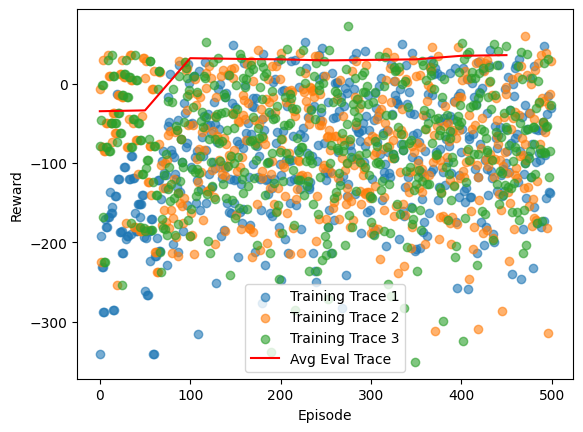

In [18]:
plot_trace(logs)

In [19]:
total, cities, actions = run_simulation(agent, env)

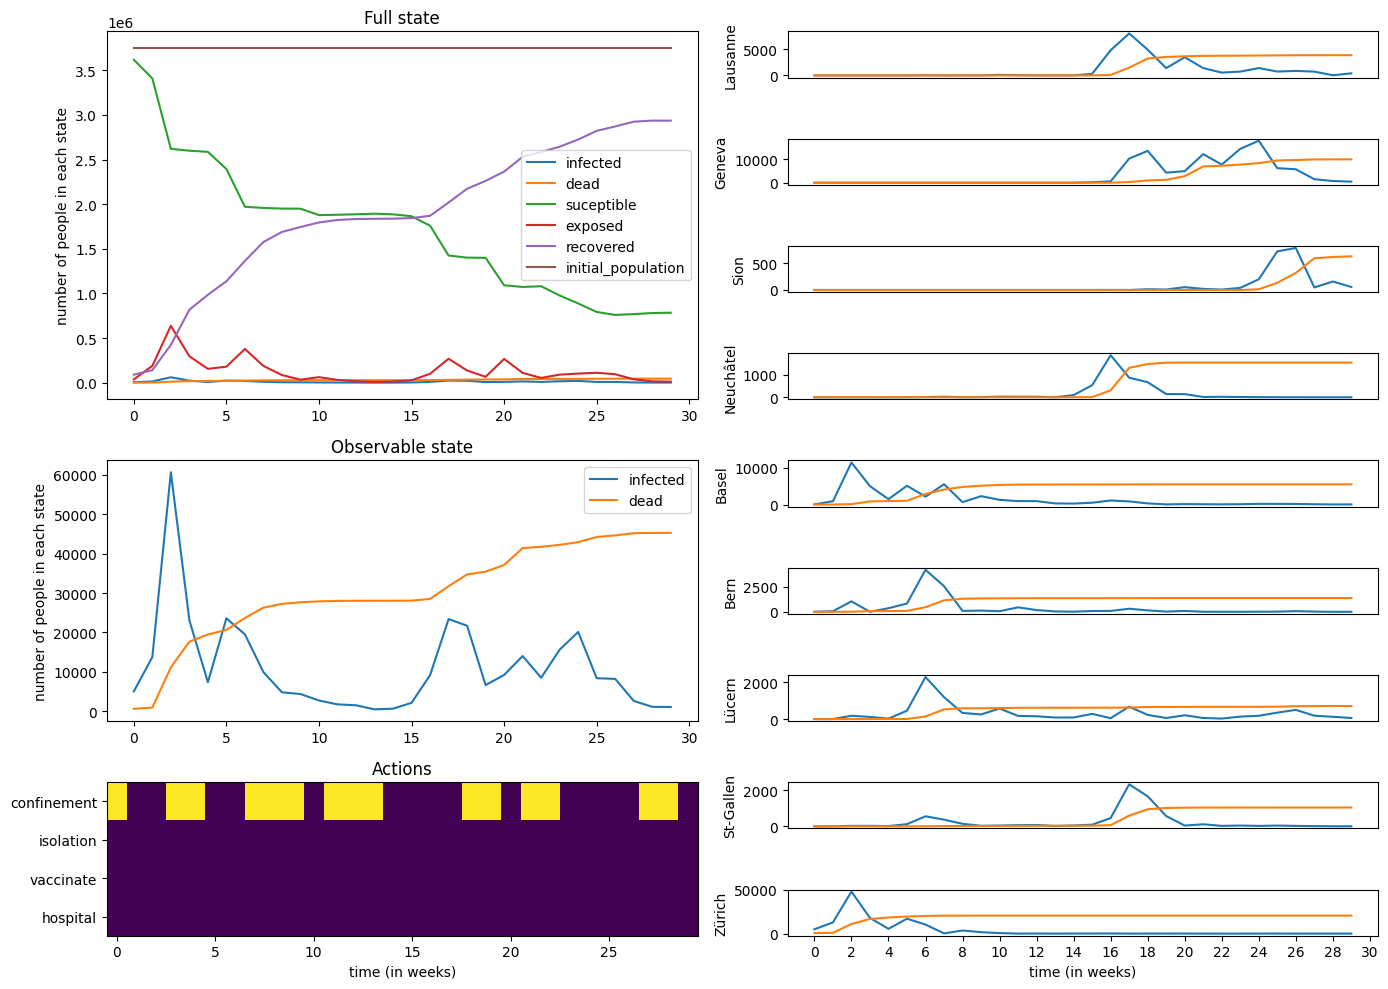

In [20]:
plot_simulation(total, cities, actions)

#### Does your agent learn a meaningful policy?
The agent seems to be learning a meaningful policy as the average evaluation reward increases over time. The randomness observed in the training trace is typical due to exploration, whereas evaluation trace uses a deterministic policy, resulting in smoother results. To confirm the meaningfulness of the policy, we should analyze if the agent's decisions in frequently encountered states lead to expected outcomes given your problem context.

#### Interpret the policy

Your agent learns a policy that alternates between confinement and relaxation to manage infections. While confinement periods effectively reduce infections, spikes occur during relaxation. The policy reflects real-world strategies, but may need refining to mitigate potential increases in mortality rates.

## 3. b) Implementing Deep Q-Learning

In [21]:
# Initialize a list to store logs from each training session
logs = []

# Number of training sessions
num_training_sessions = 3

# Train the agent multiple times
for i in range(num_training_sessions):
    print("-------- Training session n°", i + 1, " --------")
    # Initialize a new agent for each session
    agent = DQNAgent(input_shape, action_size, env, epsilon = epsilon_start, memory_size=BUFFER_SIZE, seed=seed)

    # Train the agent
    agent.train(n_episodes = 500, decay_epsilon = True)

    # Save the log from this training session
    logs.append(agent.log)


-------- Training session n° 1  --------


  0%|                                         | 1/500 [00:12<1:43:08, 12.40s/it]

Episode 1, Avg Eval Reward: -171.1403381347656 Epsilon : 0.7


 10%|████▎                                     | 51/500 [00:54<31:18,  4.18s/it]

Episode 51, Avg Eval Reward: -142.0981132507324 Epsilon : 0.63


 20%|███████▉                               | 101/500 [03:15<1:08:19, 10.27s/it]

Episode 101, Avg Eval Reward: 25.178134441375732 Epsilon : 0.56


 30%|████████████▍                            | 151/500 [05:54<28:30,  4.90s/it]

Episode 151, Avg Eval Reward: 26.436218452453613 Epsilon : 0.48999999999999994


 40%|████████████████▍                        | 201/500 [07:04<22:52,  4.59s/it]

Episode 201, Avg Eval Reward: 23.352161121368407 Epsilon : 0.42


 50%|████████████████████▌                    | 251/500 [08:08<19:00,  4.58s/it]

Episode 251, Avg Eval Reward: 29.33434534072876 Epsilon : 0.35


 60%|████████████████████████▋                | 301/500 [09:12<15:12,  4.59s/it]

Episode 301, Avg Eval Reward: 39.989903926849365 Epsilon : 0.28


 70%|████████████████████████████▊            | 351/500 [10:17<11:24,  4.59s/it]

Episode 351, Avg Eval Reward: 30.340123558044432 Epsilon : 0.21


 80%|████████████████████████████████▉        | 401/500 [11:21<07:33,  4.58s/it]

Episode 401, Avg Eval Reward: 35.47273885011673 Epsilon : 0.2


 90%|████████████████████████████████████▉    | 451/500 [12:25<03:44,  4.59s/it]

Episode 451, Avg Eval Reward: 33.12169115543365 Epsilon : 0.2


100%|█████████████████████████████████████████| 500/500 [13:17<00:00,  1.60s/it]


-------- Training session n° 2  --------


  0%|                                         | 1/500 [00:12<1:43:03, 12.39s/it]

Episode 1, Avg Eval Reward: 22.91124596595764 Epsilon : 0.7


 10%|████▎                                     | 51/500 [00:53<30:51,  4.12s/it]

Episode 51, Avg Eval Reward: 23.09325361251831 Epsilon : 0.63


 20%|███████▉                               | 101/500 [11:22<2:57:04, 26.63s/it]

Episode 101, Avg Eval Reward: 29.022265720367432 Epsilon : 0.56


 30%|███████████▊                           | 151/500 [16:57<1:54:15, 19.64s/it]

Episode 151, Avg Eval Reward: 32.24026403427124 Epsilon : 0.48999999999999994


 40%|███████████████▋                       | 201/500 [25:04<4:16:06, 51.39s/it]

Episode 201, Avg Eval Reward: 29.09351177215576 Epsilon : 0.42


 50%|███████████████████▌                   | 251/500 [31:14<1:17:01, 18.56s/it]

Episode 251, Avg Eval Reward: 29.387346863746643 Epsilon : 0.35


 60%|███████████████████████▍               | 301/500 [38:22<1:23:43, 25.24s/it]

Episode 301, Avg Eval Reward: 33.53699326515198 Epsilon : 0.28


 70%|████████████████████████████▊            | 351/500 [45:38<52:18, 21.07s/it]

Episode 351, Avg Eval Reward: 24.443277740478514 Epsilon : 0.21


 80%|███████████████████████████████▎       | 401/500 [53:36<1:17:21, 46.88s/it]

Episode 401, Avg Eval Reward: 32.92469654083252 Epsilon : 0.2


 90%|███████████████████████████████████▏   | 451/500 [1:01:45<29:19, 35.91s/it]

Episode 451, Avg Eval Reward: 39.21768407821655 Epsilon : 0.2


100%|███████████████████████████████████████| 500/500 [1:35:18<00:00, 11.44s/it]


-------- Training session n° 3  --------


  0%|                                   | 1/500 [1:04:03<532:41:41, 3843.09s/it]

Episode 1, Avg Eval Reward: 23.244754028320312 Epsilon : 0.7


 10%|███▍                              | 51/500 [6:19:00<291:38:50, 2338.37s/it]

Episode 51, Avg Eval Reward: 23.31669044494629 Epsilon : 0.63


 20%|██████▊                           | 101/500 [10:41:44<26:47:09, 241.68s/it]

Episode 101, Avg Eval Reward: 23.939447736740114 Epsilon : 0.56


 30%|███████████▍                          | 151/500 [10:43:03<27:52,  4.79s/it]

Episode 151, Avg Eval Reward: 27.793636894226076 Epsilon : 0.48999999999999994


 40%|███████████████▎                      | 201/500 [10:44:13<24:01,  4.82s/it]

Episode 201, Avg Eval Reward: 41.58582935333252 Epsilon : 0.42


 50%|███████████████████                   | 251/500 [10:45:22<19:21,  4.66s/it]

Episode 251, Avg Eval Reward: 29.82195611000061 Epsilon : 0.35


 60%|██████████████████████▉               | 301/500 [10:46:30<15:28,  4.67s/it]

Episode 301, Avg Eval Reward: 35.77566556930542 Epsilon : 0.28


 70%|██████████████████████████▋           | 351/500 [10:47:38<11:51,  4.77s/it]

Episode 351, Avg Eval Reward: 29.259916591644288 Epsilon : 0.21


 80%|██████████████████████████████▍       | 401/500 [10:48:44<07:48,  4.73s/it]

Episode 401, Avg Eval Reward: 32.6261846780777 Epsilon : 0.2


 90%|██████████████████████████████████▎   | 451/500 [10:49:52<03:49,  4.69s/it]

Episode 451, Avg Eval Reward: 40.312560844421384 Epsilon : 0.2


100%|██████████████████████████████████████| 500/500 [10:50:47<00:00, 78.09s/it]


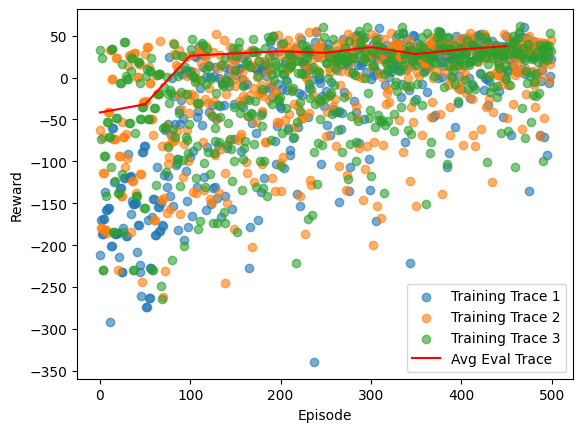

In [22]:
plot_trace(logs)

#### Compare and discuss the results between questions 3.a) and 3.b). Which policy gets the best results and why?

In both cases, the evaluation trace shows similar trends indicating effective learning. However, the training trace in the case of Deep Q-Learning with epsilon decay is less random, suggesting improved learning over time compared to the fixed epsilon approach. This indicates that the policy from epsilon decay approach provides better results. The reason for this could be that the epsilon decay method balances exploration and exploitation more effectively, allowing the agent to explore the environment initially and then increasingly exploit learned knowledge, leading to a more consistent learning process.

In [23]:
total, cities, actions = run_simulation(agent, env)

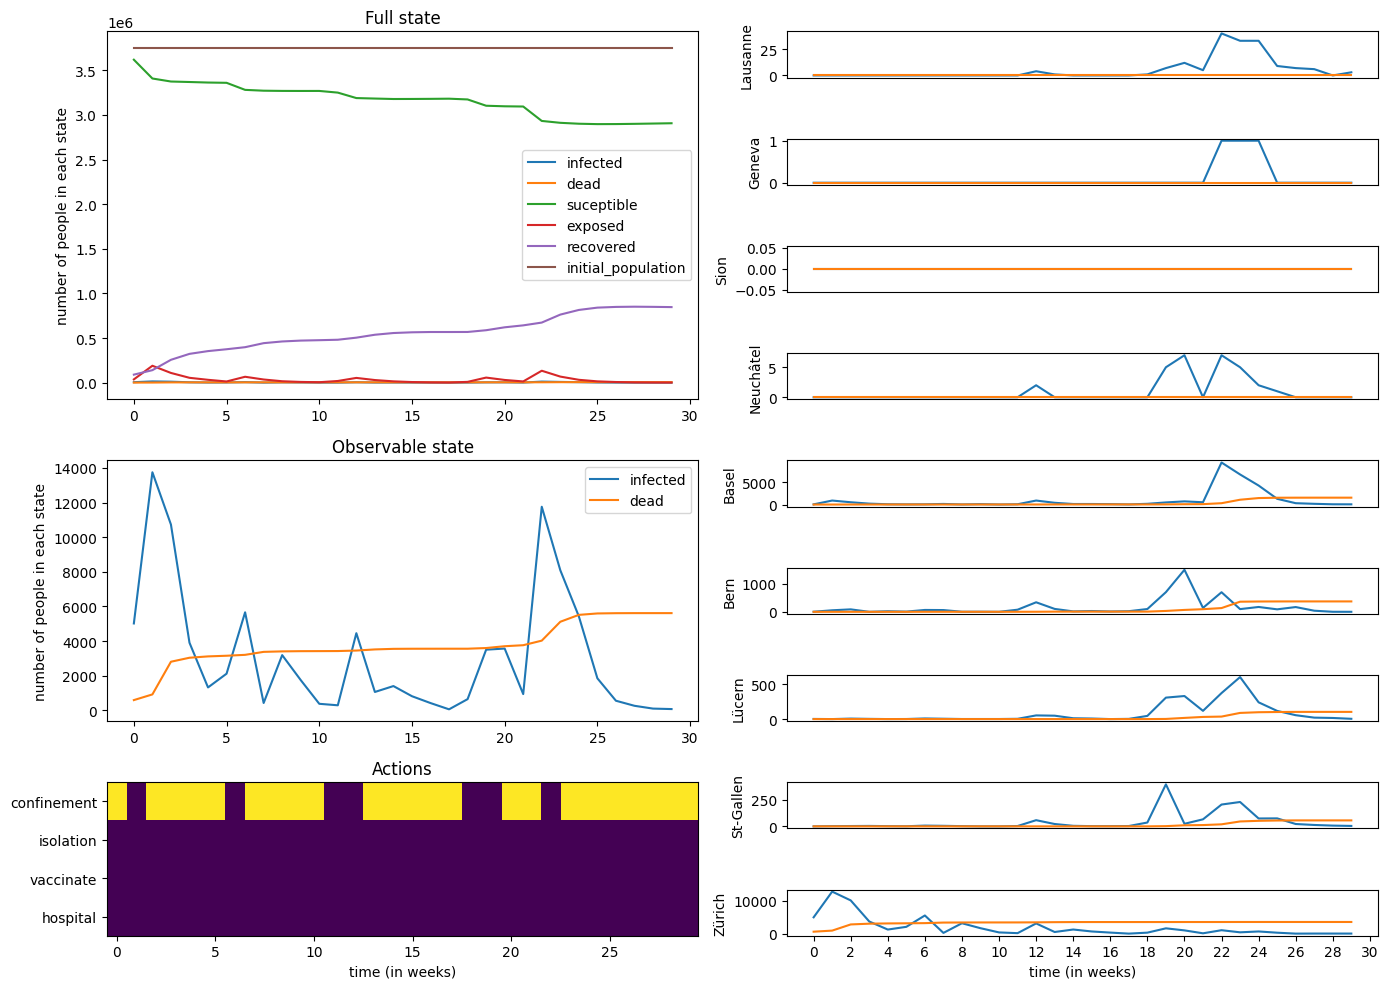

In [24]:
plot_simulation(total, cities, actions)

## 3. c) Evaluate the best performing policy against Pr. Russo’s policy

In [25]:
log_hisograms = run_several_simulations(agent, env, N_EPISODES = 50)

100%|███████████████████████████████████████████| 50/50 [00:30<00:00,  1.65it/s]


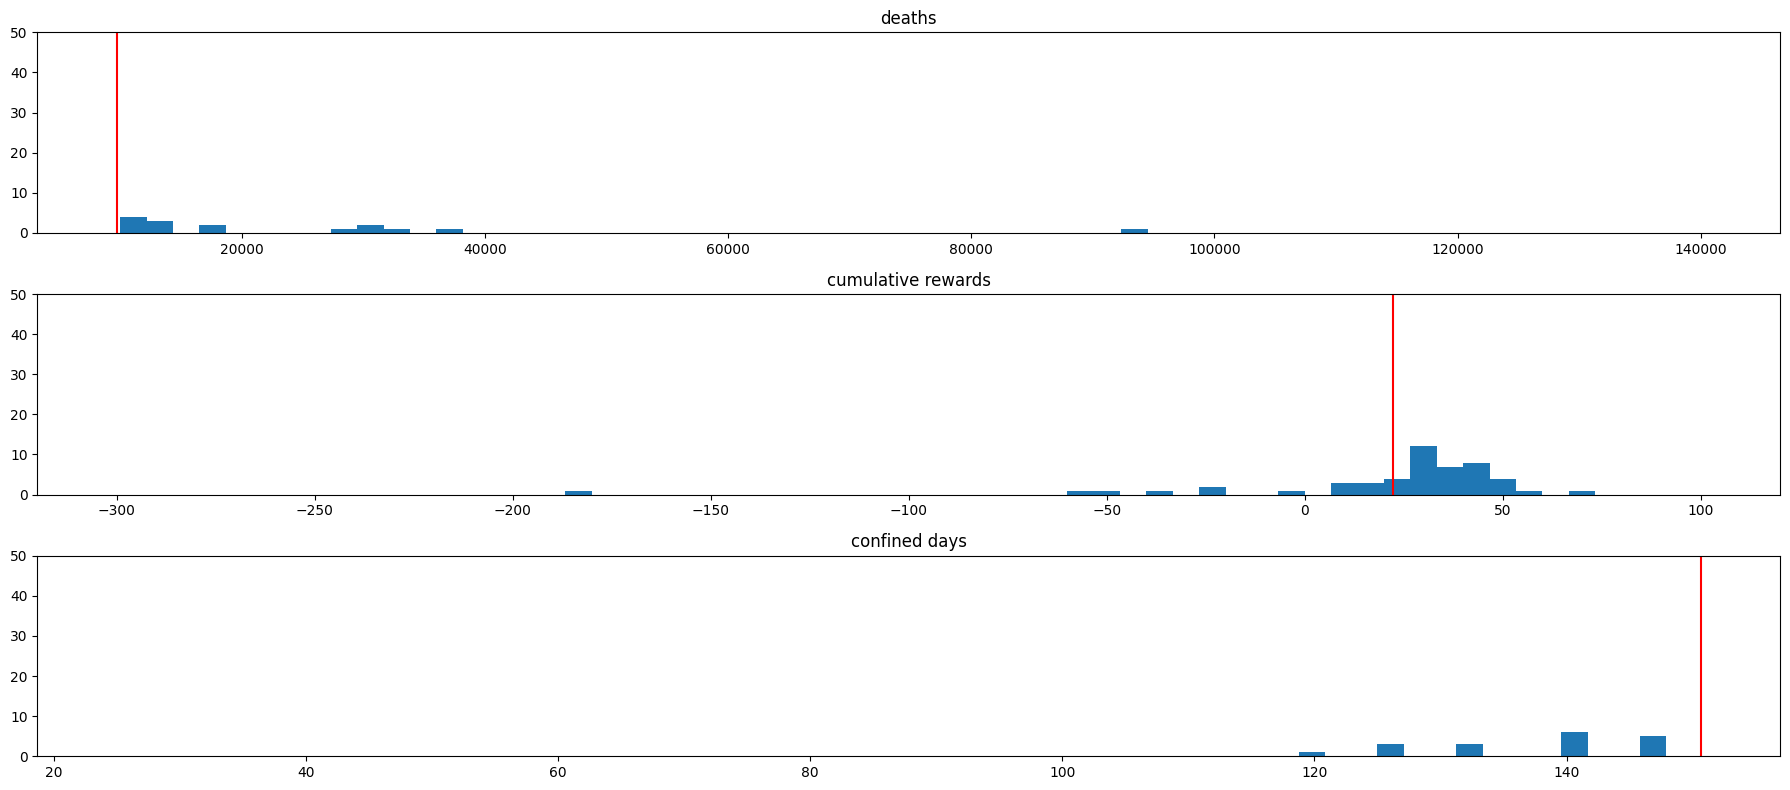

Average death number: 9689.86
Average number of confined days: 150.64
Average number of isolation days: 150.64
Average cumulative reward: 22.379840850830078


In [26]:
plot_histograms(log_hisograms)

#### Did the reinforcement learning policy outperform Pr. Russo’s, if so in what sense?

Yes, the reinforcement learning policy using Deep Q-Learning outperformed Professor Russo's policy in several key aspects. It significantly reduced the average number of total deaths, a critical health outcome, indicating a more effective control of the virus spread. Furthermore, it also achieved a higher average cumulative reward, suggesting a more efficient balance between confinement days and the resulting health and societal impacts.

# 4. Dealing with a more complex action Space

# 4.1 Toggle-action-space multi-action agent

In [39]:
SCALE = 1#00
ACTION_NULL = 0
ACTION_CONFINE = 1
ACTION_ISOLATE = 2
ACTION_HOSPITAL = 3
ACTION_VACCINATE = 4

def action_preprocessor(a:torch.Tensor, dyn:ModelDynamics):
    action = dyn.get_action()
    
    if a == ACTION_CONFINE :
        action['confinement'] = not action['confinement']
    elif a == ACTION_ISOLATE:
        action['isolation'] = not action['isolation']
    elif a == ACTION_HOSPITAL:
        action['hospital'] = not action['hospital']
    elif a == ACTION_VACCINATE:
        action['vaccinate'] = not action['vaccinate']
        
    return action
    
def observation_preprocessor(obs: Observation, dyn:ModelDynamics):
    infected = SCALE * np.array([np.array(obs.city[c].infected)/obs.pop[c] for c in dyn.cities])
    dead = SCALE * np.array([np.array(obs.city[c].dead)/obs.pop[c] for c in dyn.cities])
    confined = np.ones_like(dead)*int((dyn.get_action()['confinement']))
    infected = infected**(1/4)
    dead = dead**(1/4)
    confined = confined
    return torch.Tensor(np.stack((infected, dead, confined))).unsqueeze(0)

In [40]:
action_space        =   spaces.Discrete(5)
observation_space   =   spaces.Box( low=0,
                                    high=1,
                                    shape=(2, dyn.n_cities, dyn.env_step_length),
                                    dtype=np.float16)

In [41]:
env = Env(  dyn,
            action_space=action_space,
            observation_space=observation_space,
            action_preprocessor=action_preprocessor,
            observation_preprocessor=observation_preprocessor,
            # Don't put observation preprocessor for this case because RussoAgent needs to know the population of each cities
            )

In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import random

class DQNAgent_TOGGLE:
    def __init__(self, state_dim, action_dim, env, epsilon = 0.7, memory_size=20000, seed = 0):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.memory = deque(maxlen=memory_size)
        self.model = self.create_model()
        self.target_model = self.create_model()
        self.update_target_model()
        self.optimizer = optim.Adam(self.model.parameters(), lr = 0.001)
        self.loss_fn = nn.HuberLoss()
        self.epsilon = epsilon
        self.env = env
        
    def load_model(self, savepath):
        # This is where one would define the routine for loading a pre-trained model
        self.model = torch.load(savepath)

    def save_model(self, savepath = 'best_model.pt'):
        # This is where one would define the routine for saving the weights for a trained model
        torch.save(self.model.state_dict(), savepath)

    def create_model(self):
        model = nn.Sequential(
            nn.Linear(self.state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, self.action_dim)
        )
        return model

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())
        
    def action_state_to_vector(self, action_state):
        # Initialize an empty tensor of shape (2, 9, 7)
        action_state_vec = np.zeros(4)
        ACTION_NULL = 0
        ACTION_CONFINE = 1
        ACTION_ISOLATE = 2
        ACTION_HOSPITAL = 3
        ACTION_VACCINATE = 4
        action_state_vec[ACTION_CONFINE-1] = action_state['confinement']
        action_state_vec[ACTION_ISOLATE-1] = action_state['isolation']
        action_state_vec[ACTION_HOSPITAL-1] = action_state['hospital']
        action_state_vec[ACTION_VACCINATE-1] = action_state['vaccinate']
        
        return action_state_vec
    
    def observation_to_state(self, observation, action_state):
        state = observation[0]
        state = np.array(state.flatten())
        action_state = self.action_state_to_vector(action_state)
        state = np.append(state, action_state)

        return state


    def act(self, state, action_state):
        state = self.observation_to_state(state, action_state)
        if random.random() < self.epsilon: # Exploration
            return random.choice(range(self.action_dim))
        else: # Exploitation
            state = torch.FloatTensor(state).unsqueeze(0)
            with torch.no_grad():
                action_values = self.model(state)
            return torch.argmax(action_values).item()



    def remember(self, state, action, reward, next_state, done, action_state, next_action_state):
        state = self.observation_to_state(state, action_state)
        next_state = self.observation_to_state(next_state, next_action_state)
        
        self.memory.append((state, action, reward, next_state, done))

    def optimize_model(self, batch_size):
        if len(self.memory) < batch_size:
            return
        batch = random.sample(self.memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        states = np.array(states)
        next_states = np.array(next_states)
        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones)
        
        curr_Q = self.model(states)#.gather(1, actions.unsqueeze(1)).squeeze(1)
        curr_Q = curr_Q.gather(1, actions.unsqueeze(1)).squeeze(1)
        next_Q = self.target_model(next_states).max(1)[0]
        target_Q = rewards + (1 - dones) * 0.9 * next_Q # 0.9 is the discount factor
        loss = self.loss_fn(curr_Q, target_Q.detach())

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
    def reset(self,):
        # This should be called when the environment is reset
        pass
    
    def train(self, n_episodes = 500, eval_interval = 50, num_eval_episodes = 20, target_update_interval = 5, decay_epsilon = False, batch_size = 2048, buffer_size = 20000, epsilon_start = 0.7, epsilon_end = 0.2):
        self.log = {
            'Episode': [i + 1 for i in range(n_episodes)],
            'conf_days': [],
            'R_cumul': [],
            'N_deaths': [],
            'eval_trace': []
        }

        best_eval_reward = -np.inf

        """ Run several simulations """
        for i in tqdm(range(n_episodes)):
            finished = False
            self.reset()
            obs, info = self.env.reset()
            action_state = info.action
            next_action_state = info.action
            N_confin = 0
            R_cumul = 0

            if i % TARGET_UPDATE_INTERVAL == 0:
                agent.update_target_model()

            while not finished:
                action = self.act(obs, action_state)
                next_obs, R, finished, info = self.env.step(action)
                next_action_state = info.action

                R_cumul += R
                N_confin += info.action['confinement'] * 7

                # Store the transition in memory
                self.remember(obs, action, R, next_obs, finished, action_state, next_action_state)

                # Train the model
                self.optimize_model(batch_size)  # 32 is the batch size

                obs = next_obs
                action_state = next_action_state

                if finished:
                    break

            # Decay epsilon
            if decay_epsilon:
                new_epsilon = max(epsilon_end, epsilon_start * (n_episodes-i)/n_episodes)
                self.epsilon = new_epsilon
            else:
                new_epsilon = self.epsilon
            #print("Epsilon :", epsilon)

            self.log['conf_days'].append(N_confin)
            self.log['R_cumul'].append(R_cumul.numpy()[0])
            self.log['N_deaths'].append(info.total.dead)

            # Evaluation and logging
            if i % eval_interval == 0 or (i == n_episodes - 1 and n_episodes % eval_interval != 0):
                self.epsilon = 0 # No exploration
                eval_rewards = []
                for idx in range(num_eval_episodes):
                    obs, info = self.env.reset()
                    action_state = info.action
                    episode_reward = 0
                    done = False
                    while not done:
                        action = self.act(obs, action_state) 
                        obs, reward, done, info = self.env.step(action)
                        action_state = info.action
                        #print('Reward :', idx ,reward)
                        episode_reward += reward
                    eval_rewards.append(episode_reward)

                eval_rewards = [reward.item() for reward in eval_rewards]
                avg_eval_reward = np.mean(eval_rewards)
                self.log['eval_trace'].append(avg_eval_reward)
                
                self.epsilon = new_epsilon
                print(f"Episode {i + 1}, Avg Eval Reward: {avg_eval_reward}", "Epsilon :", self.epsilon)
                

                # Save the best model
                if avg_eval_reward > best_eval_reward:
                    best_eval_reward = avg_eval_reward
                    self.save_model('best_model.pt') # Save the best model


## 4.1. a) (Theory) Action space design

#### Discuss, the impact on network architecture and on training.

The toggle-action space adds flexibility to decision-making, especially in complex environments with long-term action effects. It requires modifications to the network architecture to accommodate the extended observation space and more possible actions, thereby potentially slowing down training. However, it can yield more nuanced policies and encourage strategic long-term behavior.

## 4.1. b) Toggle-action-space multi-action policy training

In [43]:
input_shape = 3*9*7 + 4  # 189 + 4
action_size = 5 
seed = 0  # or any other seed you want to use for reproducibility

In [44]:
agent = DQNAgent_TOGGLE(input_shape, action_size, env, epsilon = epsilon_start, memory_size=BUFFER_SIZE, seed=seed)  # Assume you've defined input_shape, action_size, seed

In [45]:
# Initialize a list to store logs from each training session
logs = []

# Number of training sessions
num_training_sessions = 3

# Train the agent multiple times
for i in range(num_training_sessions):
    print("-------- Training session n°", i + 1, " --------")
    # Initialize a new agent for each session
    agent = DQNAgent_TOGGLE(input_shape, action_size, env, epsilon = epsilon_start, memory_size=BUFFER_SIZE, seed=seed)

    # Train the agent
    agent.train(n_episodes = 500, decay_epsilon = True)

    # Save the log from this training session
    logs.append(agent.log)



-------- Training session n° 1  --------


  0%|                                         | 1/500 [00:12<1:47:50, 12.97s/it]

Episode 1, Avg Eval Reward: -165.90007476806642 Epsilon : 0.7


 10%|████▎                                     | 51/500 [00:58<31:10,  4.17s/it]

Episode 51, Avg Eval Reward: -156.61611328125 Epsilon : 0.63


 20%|████████▎                                | 101/500 [01:59<32:11,  4.84s/it]

Episode 101, Avg Eval Reward: -7.4286802291870115 Epsilon : 0.56


 30%|████████████▍                            | 151/500 [03:13<27:22,  4.71s/it]

Episode 151, Avg Eval Reward: -13.568768239021301 Epsilon : 0.48999999999999994


 40%|████████████████▍                        | 201/500 [04:22<23:45,  4.77s/it]

Episode 201, Avg Eval Reward: 31.5726591527462 Epsilon : 0.42


 50%|████████████████████▌                    | 251/500 [05:31<19:50,  4.78s/it]

Episode 251, Avg Eval Reward: 25.458751845359803 Epsilon : 0.35


 60%|████████████████████████▋                | 301/500 [06:41<15:49,  4.77s/it]

Episode 301, Avg Eval Reward: 18.469147443771362 Epsilon : 0.28


 70%|████████████████████████████▊            | 351/500 [07:50<11:49,  4.76s/it]

Episode 351, Avg Eval Reward: 27.575420713424684 Epsilon : 0.21


 80%|████████████████████████████████▉        | 401/500 [09:01<07:53,  4.78s/it]

Episode 401, Avg Eval Reward: 36.3819338798523 Epsilon : 0.2


 90%|████████████████████████████████████▉    | 451/500 [10:10<03:52,  4.75s/it]

Episode 451, Avg Eval Reward: 19.59254460334778 Epsilon : 0.2


100%|█████████████████████████████████████████| 500/500 [11:07<00:00,  1.33s/it]


-------- Training session n° 2  --------


  0%|                                         | 1/500 [00:12<1:43:50, 12.49s/it]

Episode 1, Avg Eval Reward: -257.52565612792966 Epsilon : 0.7


 10%|████▎                                     | 51/500 [00:54<31:05,  4.15s/it]

Episode 51, Avg Eval Reward: -211.993359375 Epsilon : 0.63


 20%|████████▎                                | 101/500 [01:52<31:12,  4.69s/it]

Episode 101, Avg Eval Reward: 12.536326789855957 Epsilon : 0.56


 30%|████████████▍                            | 151/500 [03:01<27:21,  4.70s/it]

Episode 151, Avg Eval Reward: 1.8523241996765136 Epsilon : 0.48999999999999994


 40%|████████████████▍                        | 201/500 [04:16<25:07,  5.04s/it]

Episode 201, Avg Eval Reward: 35.15792207717895 Epsilon : 0.42


 50%|████████████████████▌                    | 251/500 [05:30<19:42,  4.75s/it]

Episode 251, Avg Eval Reward: 22.08159441947937 Epsilon : 0.35


 60%|████████████████████████▋                | 301/500 [06:42<15:38,  4.72s/it]

Episode 301, Avg Eval Reward: 29.990512442588805 Epsilon : 0.28


 70%|████████████████████████████▊            | 351/500 [07:52<11:45,  4.74s/it]

Episode 351, Avg Eval Reward: 33.82305879592896 Epsilon : 0.21


 80%|████████████████████████████████▉        | 401/500 [09:02<07:52,  4.77s/it]

Episode 401, Avg Eval Reward: 19.64866943359375 Epsilon : 0.2


 90%|████████████████████████████████████▉    | 451/500 [10:13<03:55,  4.80s/it]

Episode 451, Avg Eval Reward: 38.831741619110105 Epsilon : 0.2


100%|█████████████████████████████████████████| 500/500 [11:10<00:00,  1.34s/it]


-------- Training session n° 3  --------


  0%|                                         | 1/500 [00:12<1:44:42, 12.59s/it]

Episode 1, Avg Eval Reward: -135.4126075744629 Epsilon : 0.7


 10%|████▎                                     | 51/500 [00:55<32:01,  4.28s/it]

Episode 51, Avg Eval Reward: -128.16973342895508 Epsilon : 0.63


 20%|████████▎                                | 101/500 [01:56<31:14,  4.70s/it]

Episode 101, Avg Eval Reward: -16.818623876571657 Epsilon : 0.56


 30%|████████████▍                            | 151/500 [03:04<27:21,  4.70s/it]

Episode 151, Avg Eval Reward: 27.596954154968262 Epsilon : 0.48999999999999994


 40%|████████████████▍                        | 201/500 [04:13<23:26,  4.71s/it]

Episode 201, Avg Eval Reward: 19.700308167934416 Epsilon : 0.42


 50%|████████████████████▌                    | 251/500 [05:22<19:37,  4.73s/it]

Episode 251, Avg Eval Reward: 24.8231153011322 Epsilon : 0.35


 60%|████████████████████████▋                | 301/500 [06:31<15:38,  4.72s/it]

Episode 301, Avg Eval Reward: 24.272855615615846 Epsilon : 0.28


 70%|████████████████████████████▊            | 351/500 [07:40<11:50,  4.77s/it]

Episode 351, Avg Eval Reward: 34.6295126914978 Epsilon : 0.21


 80%|████████████████████████████████▉        | 401/500 [08:50<07:47,  4.72s/it]

Episode 401, Avg Eval Reward: 11.375556373596192 Epsilon : 0.2


 90%|████████████████████████████████████▉    | 451/500 [09:59<03:51,  4.73s/it]

Episode 451, Avg Eval Reward: 22.53319981098175 Epsilon : 0.2


100%|█████████████████████████████████████████| 500/500 [10:56<00:00,  1.31s/it]


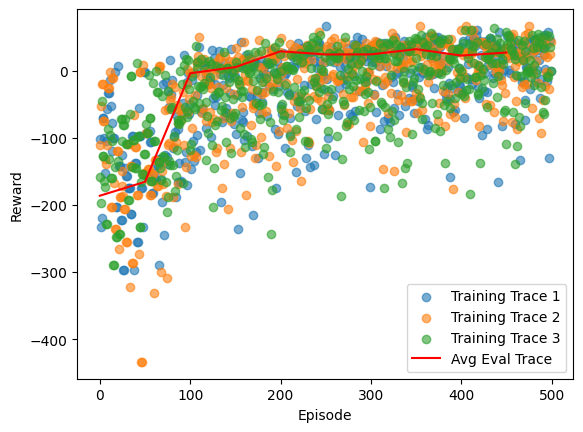

In [46]:
plot_trace(logs)

#### Is the agent properly learning?

Given that the evaluation and training traces both start at a low value and gradually increase towards a positive reward, it does suggest that the agent is learning effectively. To better understand the policy's behavior, running three episodes using the learned policy (π∗) would provide valuable insights into its decision-making process across different situations. This will help in identifying patterns in the actions taken, their corresponding states, and how these decisions lead to the observed rewards.

In [52]:
total, cities, actions = run_simulation(agent, env, toggle = True)

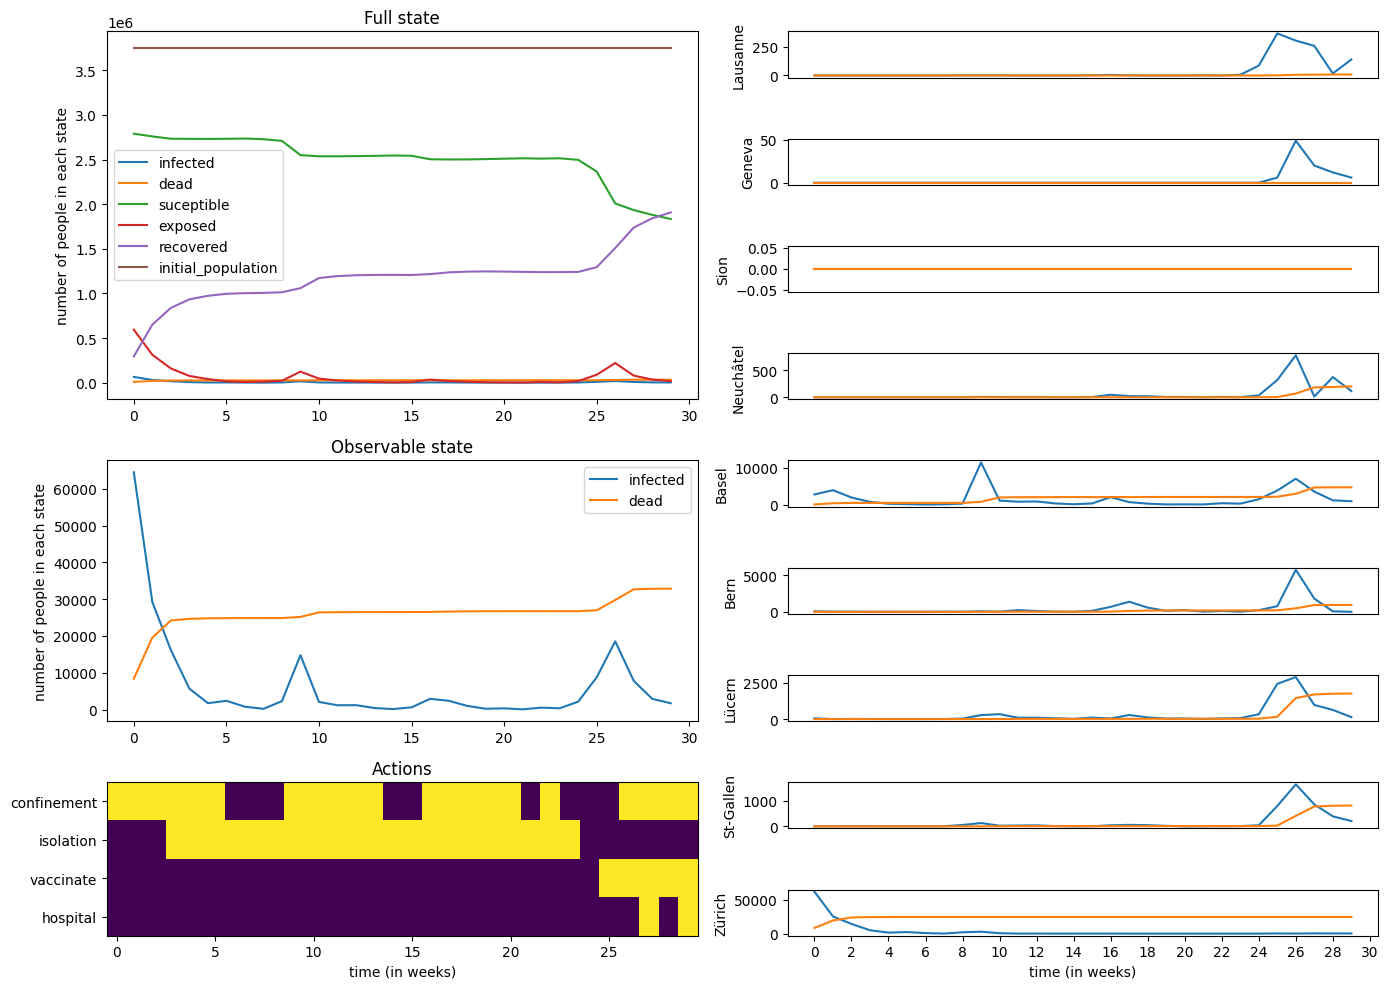

In [53]:
plot_simulation(total, cities, actions)

#### Interpret the policy.

The learned policy appears to heavily prioritize confinement and isolation measures to effectively reduce the number of susceptible and infected individuals over time. As the episode progresses, it starts introducing vaccinations and hospital provisions, indicating a shift towards recovery and prevention. The minimal time without confinement suggests a conservative strategy focused on containment to control the spread of the virus.

## 4.1. c) Toggle-action-space multi-action policy evaluation

In [47]:
log_hisograms = run_several_simulations(agent, env, N_EPISODES = 50, toggle = True)

100%|███████████████████████████████████████████| 50/50 [00:30<00:00,  1.65it/s]


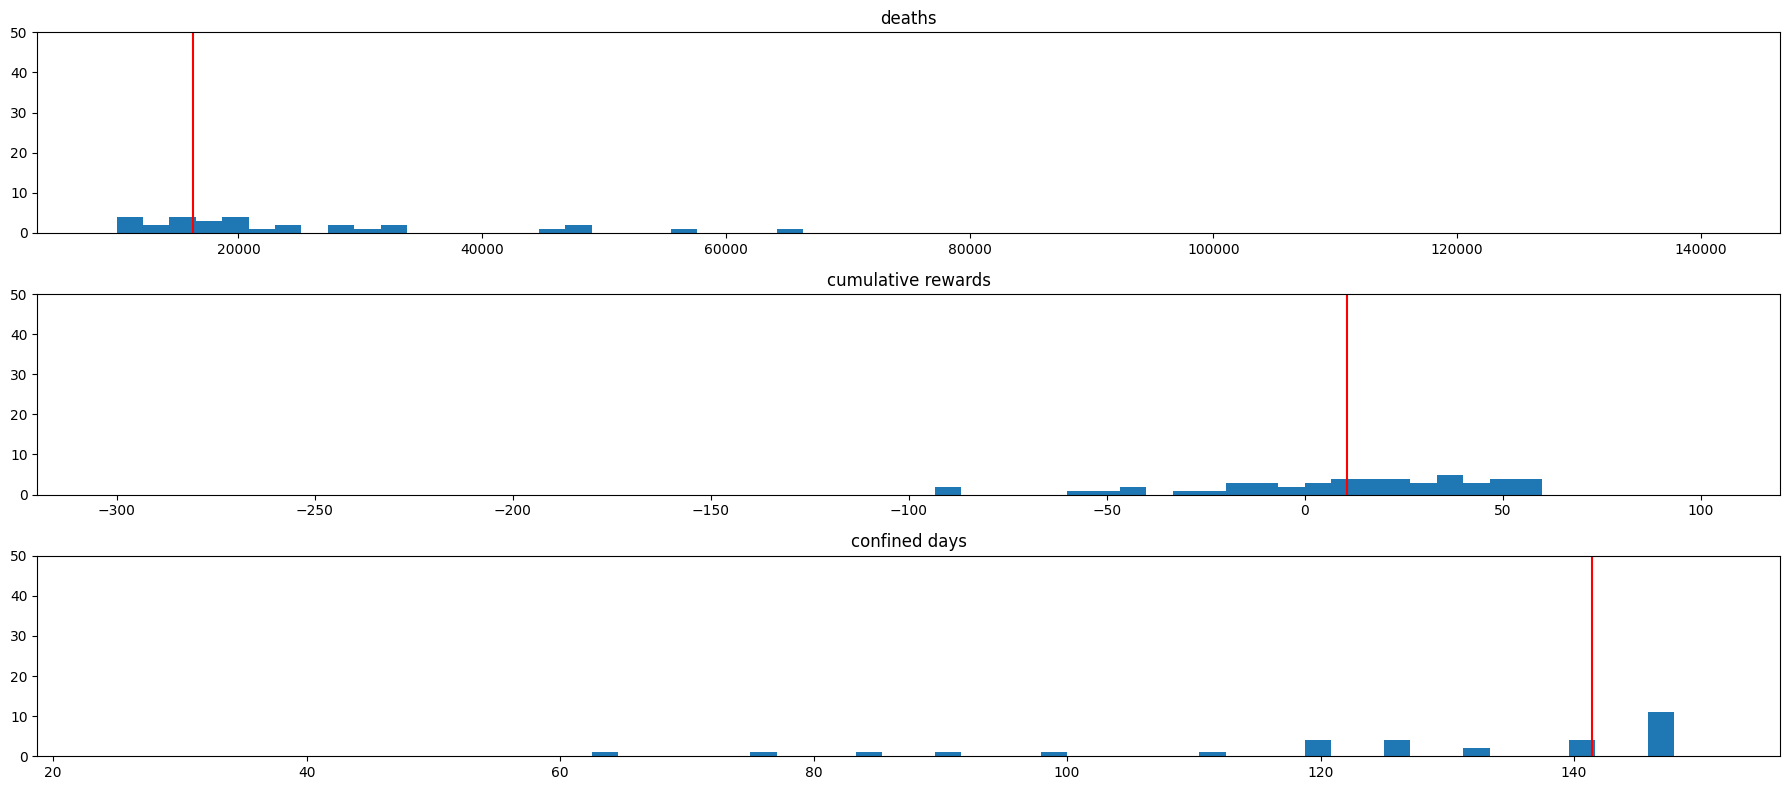

Average death number: 16263.68
Average number of confined days: 141.4
Average number of isolation days: 141.4
Average cumulative reward: 10.599349021911621


In [48]:
plot_histograms(log_hisograms)

#### How does the policy perform compared to the binary action policy evaluated in question 3.c?

Compared to the binary action policy (DQN), the toggle-action policy results in a higher average death number and fewer confinement and isolation days. However, the cumulative reward of the toggle-action policy is also higher, suggesting a more balanced approach in managing the trade-off between public health and social-economic factors. Despite the higher mortality rate, the policy achieves a positive reward while reducing the societal impact of confinement and isolation, indicating an overall better performance.

## 4.1. d) (Theory) question about toggled-action-space policy, what assumption does it make?

#### What assumptions does the use of such a technique make on the action space? Could you think of an action space for which toggling the toggle actions would not be suitable?

The use of a toggle-action-space policy assumes that the actions are binary and can be toggled between two states (e.g., on/off, true/false). This means that the impact of an action doesn't depend on its past frequency or sequence but simply on its current state.

However, toggle-actions might not be suitable for action spaces where actions have more than two states or the effect of actions is cumulative or dependent on sequence. For instance, in a game where the actions represent levels of engagement (e.g., low, medium, high), toggling wouldn't make sense. Similarly, in a navigation problem, where the action sequence matters (e.g., "go north" then "go east" leads to a different location than "go east" then "go north"), toggling would not be applicable.